# Amazon Software Products Recommender System

>  we build several types of recommender systems, including a hybrid model to generate recommendations for software products for customers on amazon.

# Overview

In this project, we work with an amazon dataset which has product review information with over 12 000 reviews across over 800 software products on Amazon. THe goal of the project is develop three different types of recommender systems - collaborative filtering system, content based filtering system and a hybrid recommender system. Within each of these types of recommenders we may build one or more models. We also perform sentiment analysis to assess the emotion or feeling around a user's review. 

***We also consider using sentiment analysis to generate possible features to include in our recommender models***.


## Data

We use an **amazon product review dataset** made available in 2018. The dataset is an updated version of the ***Amazon review dataset*** released in 2014. As in the previous version, this dataset includes **reviews** (ratings, text, helpfulness votes), product **metadata** (descriptions, category information, price, brand, and image features). We shall make use of a smaller subset of the original data. Specifically, we have the amazon product review dataset for software products only! For more information look at the dataset [homepage](https://nijianmo.github.io/amazon/index.html). 

    The dataset has over 12 000 customer reviews and has over 800 software products sold on Amazon.


## Model Evaluations and Metrics

There are a variety of metrics we can use to assess our models. Some of which are given below (which we shall use):

- ***Root Mean Squared Error (RMSE)***: This is a common metric used in collaborative filtering to evaluate the accuracy of the predicted ratings. You can calculate the RMSE by comparing the predicted ratings to the actual ratings in the dataset.

- ***Coverage***: This metric measures the percentage of unique items that are recommended to at least one user. A higher coverage indicates that the recommender system is able to recommend a wider variety of items to users.

- ***Diversity***: This metric measures the diversity of the recommendations, and is used to ensure that the recommender system is not always recommending the same set of items to all users. A higher diversity indicates that the recommender system is able to recommend a wider variety of items to different users.


# Setup and Data Loading

We begin by loading the packages for this project. We then load the datasets with our product reviews and product metadata. We then seek to merge them. 

In [73]:
# get modules 
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

In [7]:
# read in data
soft_data = pd.read_json('/Users/pavansingh/Library/CloudStorage/GoogleDrive-pavansingho23@gmail.com/My Drive/Portfolio/My Github/Recommender-Systems/Data/Amazon Data/Software_5.json',lines=True)

# view data
display(soft_data.head(3))
print("shape of Data:", soft_data.shape)

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,4,False,"10 20, 2010",A38NELQT98S4H8,0321719816,{'Format:': ' DVD-ROM'},WB Halper,I've been using Dreamweaver (and it's predeces...,A solid overview of Dreamweaver CS5,1287532800,NaN,NaN
1,4,False,"10 18, 2010",A3QJU4FEN8PQSZ,0321719816,{'Format:': ' DVD-ROM'},Grimmy,"The demo is done with the PC version, with ref...",A good value,1287360000,NaN,NaN
2,5,False,"10 16, 2010",ACJT8MUC0LRF0,0321719816,{'Format:': ' DVD-ROM'},D. Fowler,If you've been wanting to learn how to create ...,This is excellent software for those who want ...,1287187200,3,NaN


shape of Data: (12805, 12)


By setting `lines=True`, `pandas.read_json()` reads the JSON file line by line, treating each line as a separate JSON object. This is useful when you have a file that contains multiple JSON objects, each on a separate line, as is often the case with log files or other data sources that generate JSON data.



In [11]:
# structure
soft_data.dtypes

# trim data 
soft_data = soft_data[[ 'reviewerID', 'reviewerName', 'asin', 'reviewText', 'overall']]

# see new data
soft_data.head(5)

,reviewerID,reviewerName,asin,reviewText,overall
0,A38NELQT98S4H8,WB Halper,0321719816,I've been using Dreamweaver (and it's predeces...,4
1,A3QJU4FEN8PQSZ,Grimmy,0321719816,"The demo is done with the PC version, with ref...",4
2,ACJT8MUC0LRF0,D. Fowler,0321719816,If you've been wanting to learn how to create ...,5
3,AYUF7YETYOLNX,Bryan Newman,0321719816,I've been creating websites with Dreamweaver f...,5
4,A31ICLWQ9CSHRS,Al Swanson,0321719816,I decided (after trying a number of other prod...,5


In [16]:
# read in metadata
meta = pd.read_json('/Users/pavansingh/Library/CloudStorage/GoogleDrive-pavansingho23@gmail.com/My Drive/Portfolio/My Github/Recommender-Systems/Data/Amazon Data/meta_Software.json',lines=True)

# remove irrelevant columns
meta = meta[['asin', 'title', 'description', 'brand', 'price']]dsds
meta.head(8)

,asin,title,description,brand,price
0,0030672120,HOLT PHYSICS LESSON PRESENTATION CD-ROM QUICK ...,[],HOLT. RINEHART AND WINSTON,.a-box-inner{background-color:#fff}#alohaBuyBo...
1,0071480935,"Sing, Watch, &amp; Learn Spanish (DVD + Guide)...","[, <b>Latin rhythms that will get your kids si...",McGraw Hill,
2,007329506X,Connect with LearnSmart Access Card for Microb...,[<b>Connect is the only integrated learning sy...,McGraw-Hill Science/Engineering/Math,
3,0073513458,LearnSmart Standalone Access Card for Prescott...,[],McGraw-Hill Education,
4,0073525758,Anatomy &amp; Physiology Revealed Student Acce...,[<i>Anatomy &amp; Physiology Revealed Cat</i> ...,McGraw-Hill Education,$4.83
5,0077340701,Connect Math by ALEKS Access Card 52 Weeks for...,"[John Coburn grew up in the Hawaiian Islands, ...",McGraw-Hill Science/Engineering/Math,
6,0077369823,Connect Access Card for Microbiology Fundament...,[<b>Connect is the only integrated learning sy...,Brand: McGraw-Hill Science/Engineering/Math,
7,0077410297,Connect Art with McGraw-Hill LearnSmart Access...,[<i>Living with Arts </i> approach to art appr...,McGraw-Hill Humanities/Social Sciences/Languages,


In [18]:
# merge the data
soft_data = pd.merge(soft_data, softmeta_data[['asin', 'title', 'description', 'brand']], on='asin')

# view merged dataframe
soft_data.head(10)

,reviewerID,reviewerName,asin,reviewText,overall,title,description,brand
0,A38NELQT98S4H8,WB Halper,0321719816,I've been using Dreamweaver (and it's predeces...,4,Learn Adobe Dreamweaver CS5 by Video: Core Tra...,[This complete training program from Adobe Pre...,Peach Pit Press
1,A3QJU4FEN8PQSZ,Grimmy,0321719816,"The demo is done with the PC version, with ref...",4,Learn Adobe Dreamweaver CS5 by Video: Core Tra...,[This complete training program from Adobe Pre...,Peach Pit Press
2,ACJT8MUC0LRF0,D. Fowler,0321719816,If you've been wanting to learn how to create ...,5,Learn Adobe Dreamweaver CS5 by Video: Core Tra...,[This complete training program from Adobe Pre...,Peach Pit Press
3,AYUF7YETYOLNX,Bryan Newman,0321719816,I've been creating websites with Dreamweaver f...,5,Learn Adobe Dreamweaver CS5 by Video: Core Tra...,[This complete training program from Adobe Pre...,Peach Pit Press
4,A31ICLWQ9CSHRS,Al Swanson,0321719816,I decided (after trying a number of other prod...,5,Learn Adobe Dreamweaver CS5 by Video: Core Tra...,[This complete training program from Adobe Pre...,Peach Pit Press
5,A2BVNVJOFXGZUB,J. Howard,0321719816,The video is well-paced and delivered in an un...,5,Learn Adobe Dreamweaver CS5 by Video: Core Tra...,[This complete training program from Adobe Pre...,Peach Pit Press
6,A2JMJVNTBL7K7E,Yesuaini99,0321719816,I spent several hours on the lesson and I love...,5,Learn Adobe Dreamweaver CS5 by Video: Core Tra...,[This complete training program from Adobe Pre...,Peach Pit Press
7,A14JBDSWKPKTZA,Bob Feeser,0321719816,I have had Dreamweaver MX2004 since it came ou...,5,Learn Adobe Dreamweaver CS5 by Video: Core Tra...,[This complete training program from Adobe Pre...,Peach Pit Press
8,A2WCFDOCS73PNB,Gadgetman,0321719816,I have also taken a local community college on...,5,Learn Adobe Dreamweaver CS5 by Video: Core Tra...,[This complete training program from Adobe Pre...,Peach Pit Press
9,A14638TGYH7GD9,Rebecca Haden,0321719816,Even though I use Dreamweaver a great deal and...,5,Learn Adobe Dreamweaver CS5 by Video: Core Tra...,[This complete training program from Adobe Pre...,Peach Pit Press


***
# Data Exploration

In [65]:
# descriptive statistics for ratings
soft_data['overall'].describe()

count    14103.00000
mean         3.94214
std          1.35304
min          1.00000
25%          3.00000
50%          4.00000
75%          5.00000
max          5.00000
Name: overall, dtype: float64

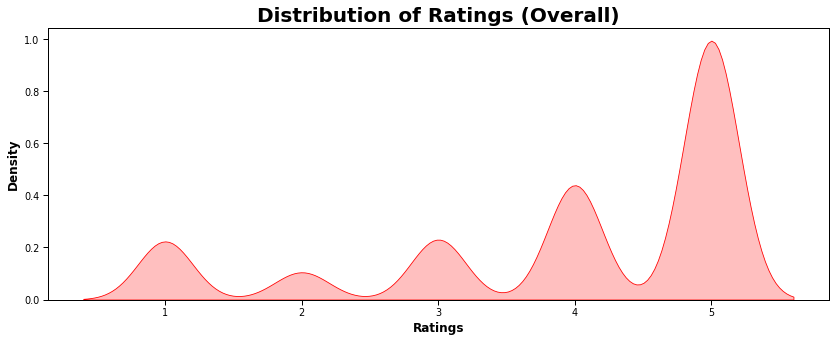

In [72]:
fig = plt.figure(figsize=(14,5))
sns.set_context("paper",font_scale=1.1)

ax = sns.kdeplot(soft_data['overall'],
                 color="Red", shade = True)
ax.set_ylabel('Density', fontsize=12, fontweight='bold')
ax.set_xlabel('Ratings', fontsize=12, fontweight='bold')
ax.set_title('Distribution of Ratings (Overall)', fontsize=20, fontweight='bold');

In [60]:
# How many customers
print("Number of Customers:", soft_data.reviewerID.unique().size)

# Count Reviews and Average Rating per Customer
cust_data = soft_data.groupby(['reviewerID']).agg({"overall": ["count", "mean"]})
cust_data.columns = ['count_rev', 'mean_rat']
cust_data['mean_rat'] = np.round(cust_data.mean_rat,3)
display(cust_data.head(4))

Number of Customers: 1826


,count_rev,mean_rat
reviewerID,,
A100UD67AHFODS,5,4.80
A105S56ODHGJEK,29,3.69
A1075X1Q4M3S78,5,5.00


Text(0.5, 1.0, 'Average Ratings by Number of Reviews')

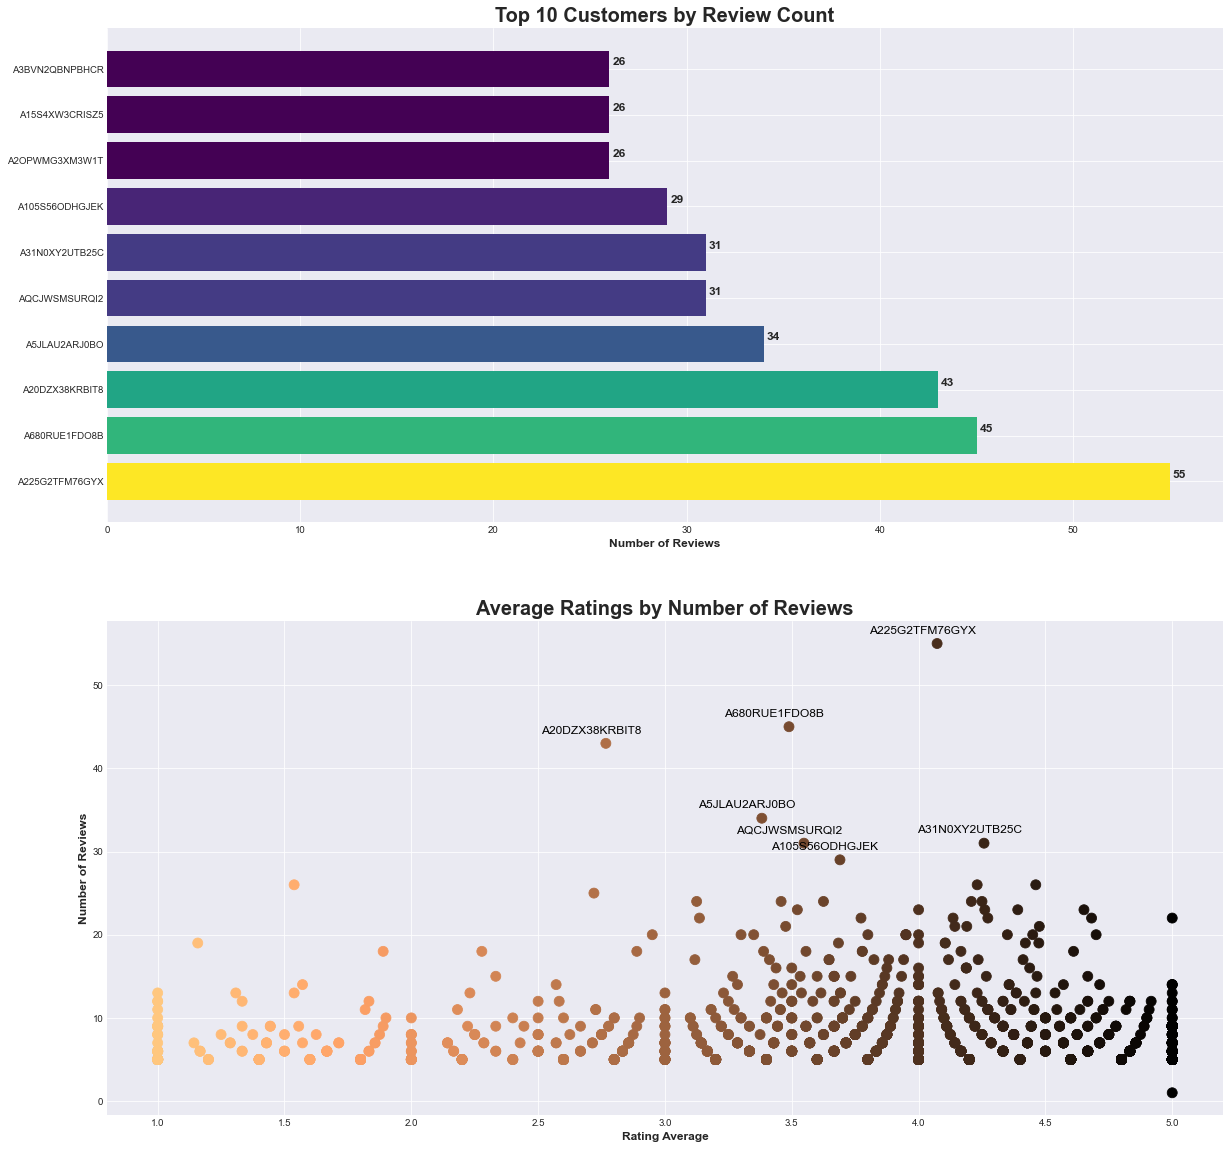

In [110]:
# Plot of Most - bar plot
plt.style.use('seaborn-darkgrid')
sample_top = cust_data.sort_values(['count_rev'], ascending=False).head(10)
count_min = sample_top.count_rev.min() # get range
count_max = sample_top.count_rev.max()
count_norm = (sample_top.count_rev - count_min) / (count_max - count_min) # Normalize 
colors = cm.viridis(count_norm) # Use a colormap to map vote average


fig = plt.figure(figsize=(20, 20))
plt.subplot(2, 1, 1)
bar = plt.barh(y=sample_top.index, width=sample_top.count_rev, color=colors)
plt.title("Top 10 Customers by Review Count", fontsize=20, fontweight='bold')
plt.xlabel("Number of Reviews", fontsize=12, fontweight='semibold')
plt.ylabel("", fontsize=12, fontweight='semibold')
for i, value in enumerate(bar.patches):
    height = value.get_width()
    plt.annotate(f'{height}',
                xy=(height, value.get_y()),
                xytext=(3, 25), 
                textcoords="offset points",
                ha='left', va='center',
                weight='semibold',
                fontsize=12)

# Plot of Average Rating vs Count Reviews - scatter plot
plt.subplot(2, 1, 2)
plt.scatter(cust_data.mean_rat, cust_data.count_rev, c=cust_data.mean_rat, cmap='copper_r', s=100)
plt.xlabel('Rating Average', fontsize=12, fontweight='semibold')
plt.ylabel('Number of Reviews', fontsize=12, fontweight='semibold')
for i, id in enumerate(cust_data.index):
    if (cust_data.count_rev[i] > 26):
        plt.annotate(id, (cust_data.loc[cust_data.index==id, "mean_rat"], cust_data.loc[cust_data.index==id, "count_rev"]), textcoords="offset points", xytext=(-15,10), ha='center', fontsize=12, color='black')
    else: continue
plt.title("Average Ratings by Number of Reviews", fontsize=20, fontweight='bold')


In [108]:
# How many items/products?
print("Number of Products:", soft_data.asin.unique().size)

# Number reviews and average ratings per product
prod_data = soft_data.groupby(['asin']).agg({"overall": ["count", "mean"]})
prod_data.columns = ['count_rev', 'mean_rat']
prod_data['mean_rat'] = np.round(prod_data.mean_rat,3)
display(prod_data.head(4))

Number of Products: 802


,count_rev,mean_rat
asin,,
0321700945,8,4.750
0321719816,14,4.571
0321719824,9,4.222
0763855553,36,4.028


Text(0.5, 1.0, 'Average Ratings by Number of Reviews')

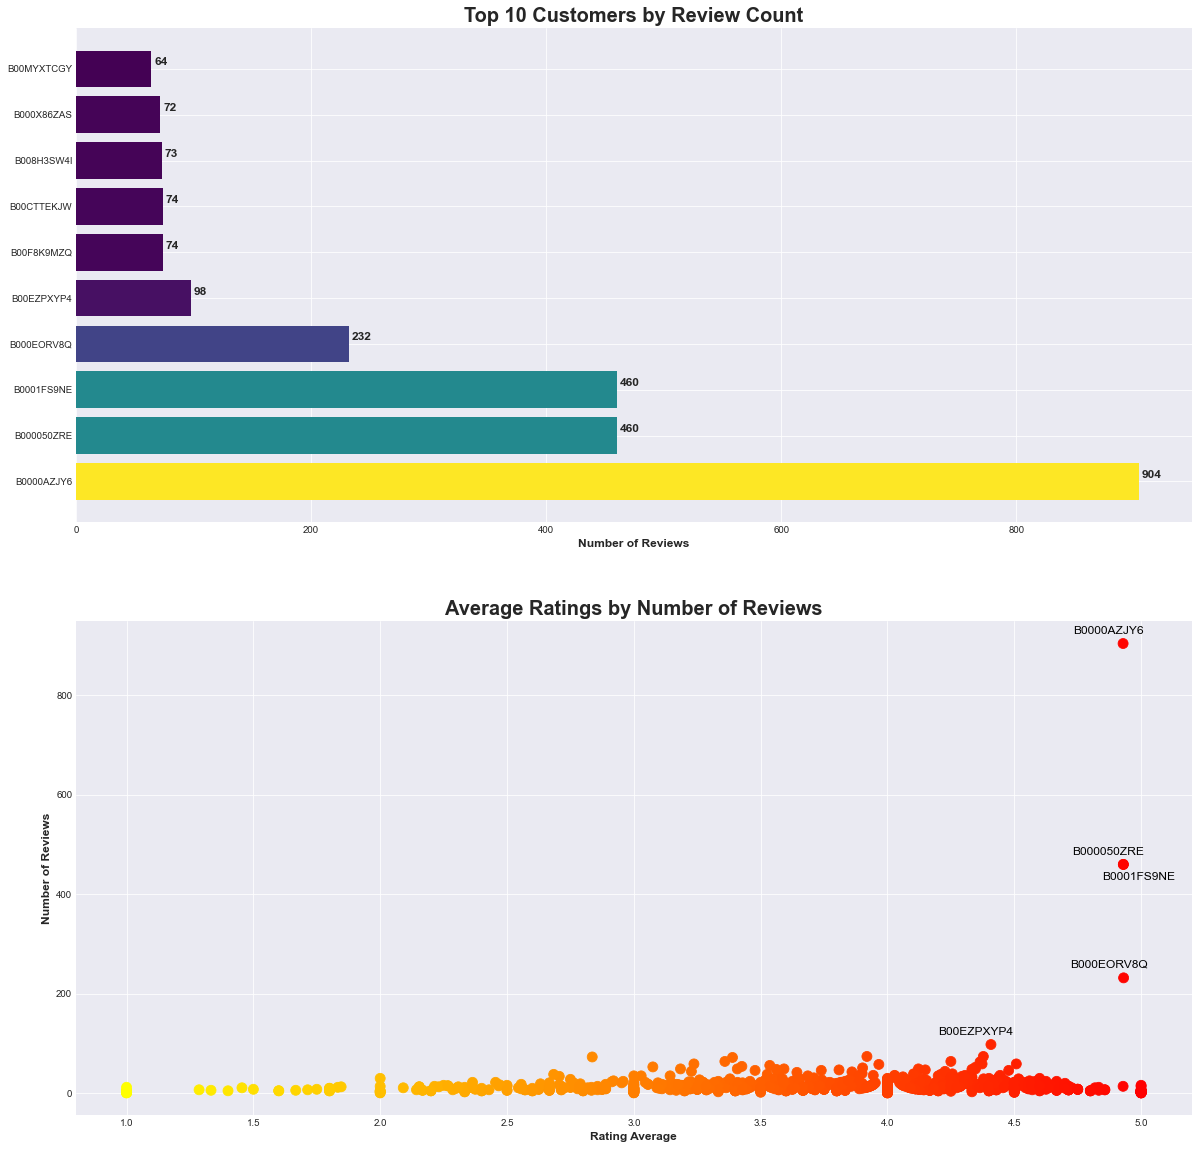

In [129]:
# Plot of Most / Fewest Reviews 
plt.style.use('seaborn-darkgrid')
sample_top = prod_data.sort_values(['count_rev'], ascending=False).head(10)
count_min = sample_top.count_rev.min() # get range
count_max = sample_top.count_rev.max()
count_norm = (sample_top.count_rev - count_min) / (count_max - count_min) # Normalize 
colors = cm.viridis(count_norm) # Use a colormap to map vote average

fig = plt.figure(figsize=(20, 20))
plt.subplot(2, 1, 1)
bar = plt.barh(y=sample_top.index, width=sample_top.count_rev, color=colors)
plt.title("Top 10 Customers by Review Count", fontsize=20, fontweight='bold')
plt.xlabel("Number of Reviews", fontsize=12, fontweight='semibold')
plt.ylabel("", fontsize=12, fontweight='semibold')
for i, value in enumerate(bar.patches):
    height = value.get_width()
    plt.annotate(f'{height}',
                xy=(height, value.get_y()),
                xytext=(3, 25), 
                textcoords="offset points",
                ha='left', va='center',
                weight='semibold',
                fontsize=12)

# Plot of Average Rating vs Count Reviews
plt.subplot(2, 1, 2)
plt.scatter(prod_data.mean_rat, prod_data.count_rev, c=prod_data.mean_rat, cmap='autumn_r', s=100)
plt.xlabel('Rating Average', fontsize=12, fontweight='semibold')
plt.ylabel('Number of Reviews', fontsize=12, fontweight='semibold')
for i, id in enumerate(prod_data.index):
    if (prod_data.count_rev[i] >= 98):
        if id == 'B0001FS9NE':
            xytext = (15, -15)
        else: xytext=(-15,10)
        plt.annotate(id, (prod_data.loc[prod_data.index==id, "mean_rat"], prod_data.loc[prod_data.index==id, "count_rev"]), textcoords="offset points",xytext=xytext, ha='center', fontsize=12, color='black')
    else: continue
plt.title("Average Ratings by Number of Reviews", fontsize=20, fontweight='bold')

***
# Sentiment Analysis

Sentiment analysis is the study of the emotional content of a body of text. 

- We shall look briefly at sentiment lexicons. 
- We shall then aggregating sentiments over words to assess sentiments of longer texts. 
- We shall also look at handling “negation” words like “not” that affect sentiment

### Sentiment Lexicons

One way of approaching the problem is to **assess the sentiment of individual words**, and then aggregate the sentiments of the words in a body of text in some way. For example, if we can classify whether each word is positive, negative, or neutral, we can count up the number of positive, negative, and neutral words in the document and define that as the sentiment of the document. This is just one way - a particularly simple way - of doing document-level sentiment analysis.

When assessing the sentiment or emotional content of individual words, we usually make use of **existing sentiment dictionaries (or “lexicons”)** that have already done this using some kind of manual classification.

> The gist is that we are dealing with a specific, pre-defined vocabulary.

> The goal is usually to assign a sentiment score to a text, possibly an overall score, or a generally positive or negative grade

***TLDR; Lexicons are dictionaries or lists that contain words with their corresponding positive or negative polarity scores***

We shall use three different lexicons:

1. **Bing**: a list of English words with their corresponding positive and negative polarity scores. The scores range from -5 (most negative) to 5 (most positive), with 0 indicating neutral sentiment.
2. **NRC**: a lexicon of English words with their corresponding scores on eight different emotions: anger, fear, anticipation, trust, surprise, sadness, joy, and disgust.
3. **AFINN**: a list of English words with their corresponding positive and negative polarity scores. The scores range from -5 (most negative) to 5 (most positive), with 0 indicating neutral sentiment.


In [143]:
# read lexicons in
afinn = pd.read_csv('/Users/pavansingh/Library/CloudStorage/GoogleDrive-pavansingho23@gmail.com/My Drive/Portfolio/My Github/Recommender-Systems/Data/Lexicons/Afinn.csv')
bing = pd.read_csv('/Users/pavansingh/Library/CloudStorage/GoogleDrive-pavansingho23@gmail.com/My Drive/Portfolio/My Github/Recommender-Systems/Data/Lexicons/Bing.csv')
nrc = pd.read_csv('/Users/pavansingh/Library/CloudStorage/GoogleDrive-pavansingho23@gmail.com/My Drive/Portfolio/My Github/Recommender-Systems/Data/Lexicons/NRC.csv')


In [151]:
# AFINN
print("Shape of AFINN:", afinn.shape)
print("Unique Sentiments:", afinn.value.unique())
display(afinn.head(5))

# BING
print("Shape of Bing:", bing.shape)
print("Unique Sentiments:", bing.sentiment.unique())
display(bing.head(5))


# NRC
print("Shape of NRC:", nrc.shape)
print("Unique Sentiments:", nrc.sentiment.unique())
display(nrc.head(5))


Shape of AFINN: (2477, 2)
Unique Sentiments: [-2 -3  2  1 -1  3  4 -4 -5  5  0]


,word,value
0,abandon,-2
1,abandoned,-2
2,abandons,-2
3,abducted,-2
4,abduction,-2


Shape of Bing: (6786, 2)
Unique Sentiments: ['negative' 'positive']


,word,sentiment
0,faces,negative
1,abnormal,negative
2,abolish,negative
3,abominable,negative
4,abominably,negative


Shape of NRC: (13901, 2)
Unique Sentiments: ['trust' 'fear' 'negative' 'sadness' 'anger' 'surprise' 'positive'
 'disgust' 'joy' 'anticipation']


,word,sentiment
0,abacus,trust
1,abandon,fear
2,abandon,negative
3,abandon,sadness
4,abandoned,anger


***
# Collaborative Filtering




## Non-negative Matrix Factorisation

## Deep Matrix Factorisation

## Neural Collaborative Filtering

***
# Content Based Filtering

## Using Review Text, Titles and Brand

***
# Hybrid Recommender Model

## Content Based & Collaborative Filtering

***
# Results and Conclusion